## **Install and Import Dependencies (PyTorch + NLP + Vision)**

In [1]:
!pip install keras
!pip install tensorflow

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import optim

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import re
import spacy

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [4]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import os
from dotenv import load_dotenv

# Load variables from .env
load_dotenv()

# Get token
hf_token = os.getenv("HF_TOKEN")

# Login securely
from huggingface_hub import login
login(token=hf_token)

## **Load Mirage-News Dataset**

In [6]:
!pip install datasets --quiet

from datasets import load_dataset

dataset = load_dataset("anson-huang/mirage-news")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
from datasets import load_dataset

dataset = load_dataset("anson-huang/mirage-news")

df = dataset['train'].to_pandas()

print("Available columns:", df.columns.tolist())

df.head()

Available columns: ['image', 'label', 'text']


,image,label,text
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1,"Andal Ampatuan Jr., a notorious crime lord in ..."
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1,"Senator Christopher J. Dodd, with his wife and..."
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1,An immigrant viciously attacks medical personn...
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1,Violent clashes break out in San Francisco on ...
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1,A man closes the door of the house after plant...


In [8]:
print("Columns in dataset:", df.columns.tolist())

print("\nMissing values:")
print(df.isnull().sum())

print("\nLabel distribution:")
print(df['label'].value_counts())

Columns in dataset: ['image', 'label', 'text']

Missing values:
image    0
label    0
text     0
dtype: int64

Label distribution:
label
1    5000
0    5000
Name: count, dtype: int64


In [9]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## **Clean Data Loading, Text Preprocessing, Saving Images and Splitting**

In [10]:
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import os
from PIL import Image
from io import BytesIO
from tqdm import tqdm

dataset = load_dataset("anson-huang/mirage-news")
df = dataset["train"].to_pandas()

df = df.dropna(subset=["text", "image"])
df = df[df["text"].str.strip() != ""]

print("Total usable samples:", len(df))

train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df["label"],
    random_state=42
)

valid_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["label"],
    random_state=42
)

for split_df in [train_df, valid_df, test_df]:
    split_df["clean_title"] = split_df["text"]
    split_df["6_way_label"] = split_df["label"]

train_news = list(train_df["clean_title"])
train_labels = list(train_df["6_way_label"])
train_images = list(train_df["image"])

valid_news = list(valid_df["clean_title"])
valid_labels = list(valid_df["6_way_label"])
valid_images = list(valid_df["image"])

test_news = list(test_df["clean_title"])
test_labels = list(test_df["6_way_label"])
test_images = list(test_df["image"])

train_images_final = [f"/content/mirage_news_images/train/train_image_{i}.jpg" for i in range(len(train_images))]
valid_images_final = [f"/content/mirage_news_images/valid/valid_image_{i}.jpg" for i in range(len(valid_images))]
test_images_final  = [f"/content/mirage_news_images/test/test_image_{i}.jpg" for i in range(len(test_images))]

print("Split complete:")
print(f"Train size: {len(train_news)}")
print(f"Valid size: {len(valid_news)}")
print(f"Test size : {len(test_news)}")
print(f"Sample train image filenames: {train_images_final[:5]}")

os.makedirs("/content/mirage_news_images/train", exist_ok=True)
os.makedirs("/content/mirage_news_images/valid", exist_ok=True)
os.makedirs("/content/mirage_news_images/test", exist_ok=True)

def save_images(image_objs, paths, split_name):
    print(f"Saving {split_name} images...")
    for img, path in tqdm(zip(image_objs, paths), total=len(paths)):
        if not os.path.exists(path):
            image = Image.open(BytesIO(img["bytes"]))
            if image.mode != "RGB":
                image = image.convert("RGB")
            image.save(path)

save_images(train_images, train_images_final, "train")
save_images(valid_images, valid_images_final, "valid")
save_images(test_images, test_images_final, "test")

missing_train_images = [img_path for img_path in train_images_final if not os.path.exists(img_path)]

if missing_train_images:
    print("Missing train images:", missing_train_images)
else:
    print("All train images are correctly saved.")

✅ Total usable samples: 10000
✅ Split complete:
Train size: 7000
Valid size: 1500
Test size : 1500
Sample train image filenames: ['/content/mirage_news_images/train/train_image_0.jpg', '/content/mirage_news_images/train/train_image_1.jpg', '/content/mirage_news_images/train/train_image_2.jpg', '/content/mirage_news_images/train/train_image_3.jpg', '/content/mirage_news_images/train/train_image_4.jpg']
🔄 Saving train images...


100%|██████████| 7000/7000 [00:00<00:00, 51199.64it/s]


🔄 Saving valid images...


100%|██████████| 1500/1500 [00:00<00:00, 51635.34it/s]


🔄 Saving test images...


100%|██████████| 1500/1500 [00:00<00:00, 49057.33it/s]

✅ All train images are correctly saved.


Random Training Image Path: /content/mirage_news_images/train/train_image_2342.jpg


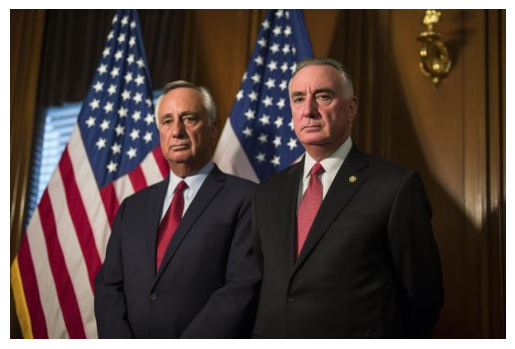

Random Validation Image Path: /content/mirage_news_images/valid/valid_image_50.jpg


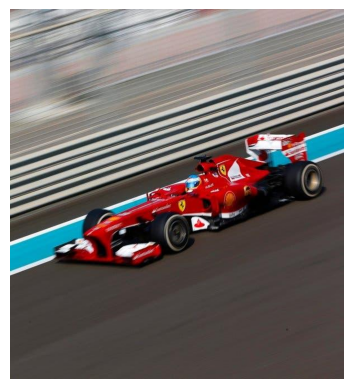

Random Test Image Path: /content/mirage_news_images/test/test_image_173.jpg


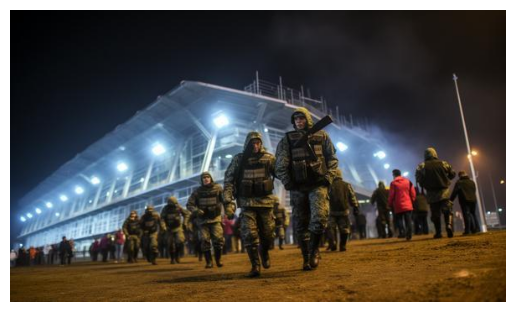

In [11]:
import random
import cv2
import matplotlib.pyplot as plt

def display_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

train_image_path = random.choice(train_images_final)
valid_image_path = random.choice(valid_images_final)
test_image_path = random.choice(test_images_final)

print("Random Training Image Path:", train_image_path)
display_image(train_image_path)

print("Random Validation Image Path:", valid_image_path)
display_image(valid_image_path)

print("Random Test Image Path:", test_image_path)
display_image(test_image_path)

## **Word Embeddings**

In [12]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-04-24 09:52:22--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-24 09:52:22--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-24 09:52:23--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [13]:
!rm -f /content/glove.6B.zip /content/glove.6B.zip.1 /content/glove.6B.zip.2
!wget http://nlp.stanford.edu/data/glove.6B.zip -O /content/glove.6B.zip
!unzip -q /content/glove.6B.zip -d /content/glove.6B/

--2025-04-24 09:53:37--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-24 09:53:37--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-24 09:53:38--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/content/glove.6B.z

In [14]:
!unzip -q /content/glove.6B.zip -d /content/glove.6B/

[/content/glove.6B.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/glove.6B.zip or
        /content/glove.6B.zip.zip, and cannot find /content/glove.6B.zip.ZIP, period.


In [15]:
import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(sen):
    if not isinstance(sen, str):
        return ""
    sentence = re.sub('[^a-zA-Z]', ' ', sen)
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence.strip()

train_news_clean_1 = [preprocess_text(new) for new in train_news]
valid_news_clean_1 = [preprocess_text(new) for new in valid_news]
test_news_clean_1 = [preprocess_text(new) for new in test_news]

def remove_stopwords_lem(text):
    if not text:
        return ""
    text = word_tokenize(text.lower())
    text = [word for word in text if word not in stop_words]
    lemmatized_text = [
        lemmatizer.lemmatize(lemmatizer.lemmatize(lemmatizer.lemmatize(word, pos="n"), pos="v"), pos="a")
        for word in text
    ]
    return ' '.join(lemmatized_text)

train_stwrd_lem = [remove_stopwords_lem(new) for new in train_news_clean_1]
valid_stwrd_lem = [remove_stopwords_lem(new) for new in valid_news_clean_1]
test_stwrd_lem = [remove_stopwords_lem(new) for new in test_news_clean_1]

news_all = train_stwrd_lem + valid_stwrd_lem + test_stwrd_lem
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(news_all)

train_tokenized = tokenizer.texts_to_sequences(train_stwrd_lem)
valid_tokenized = tokenizer.texts_to_sequences(valid_stwrd_lem)
test_tokenized = tokenizer.texts_to_sequences(test_stwrd_lem)

maxlen = 25
train_tokenized_pad = pad_sequences(train_tokenized, maxlen=maxlen, truncating='post', padding='post')
valid_tokenized_pad = pad_sequences(valid_tokenized, maxlen=maxlen, truncating='post', padding='post')
test_tokenized_pad = pad_sequences(test_tokenized, maxlen=maxlen, truncating='post', padding='post')

def load_embedd(filename):
    words, vectors = [], []
    with open(filename, 'r', encoding="utf8") as file:
        for line in file:
            row = line.split()
            vocab = row[0]
            embd = list(map(float, row[1:]))
            words.append(vocab)
            vectors.append(embd)
    return words, vectors

def embed_matx(word_index, vocab, embeddings, length_vocab, length_embedding):
    embedding_matrix = np.zeros((length_vocab + 1, length_embedding))
    embedding_dict = {word: vector for word, vector in zip(vocab, embeddings)}
    for word, i in word_index.items():
        if i > length_vocab:
            continue
        if word in embedding_dict:
            embedding_matrix[i] = embedding_dict[word]
    return embedding_matrix

glove_path = "/content/glove.6B/glove.6B.300d.txt"
vocab_gv_300, vectors_gv_300 = load_embedd(glove_path)
embedding_matrix_gv_300 = embed_matx(
    tokenizer.word_index, vocab_gv_300, vectors_gv_300,
    length_vocab=len(tokenizer.word_index), length_embedding=300
)

print("Preprocessing complete.")
print("Vocabulary length:", len(tokenizer.word_index))
print("Embedding matrix shape:", embedding_matrix_gv_300.shape)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


✅ Preprocessing complete.
Vocabulary length: 11439
Embedding matrix shape: (11440, 300)


In [16]:
from datasets import load_dataset

dataset = load_dataset("anson-huang/mirage-news")
df = dataset["train"].to_pandas()

print(df["image"].iloc[0])
print(type(df["image"].iloc[0]))

Sample image data: {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x01a\x02X\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\x

## **Image Preprocessing, Dataset Construction, and Text Sequence Padding**

In [17]:
import os
from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset
import torch
import io
import cv2

IMAGE_SIZE = 224

def pad_images(img):
    img_resized = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img_resized = img_resized.transpose((2, 0, 1))
    return (img_resized / 255.0).astype(np.float32)

dataset = load_dataset("anson-huang/mirage-news")
df = dataset["train"].to_pandas()
df = df.dropna(subset=["text", "image"])
df = df[df["text"].str.strip() != ""]

train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df["label"], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

for split_df in [train_df, valid_df, test_df]:
    split_df["clean_title"] = split_df["text"]
    split_df["6_way_label"] = split_df["label"]

train_news, train_labels, train_images = list(train_df["clean_title"]), list(train_df["6_way_label"]), list(train_df["image"])
valid_news, valid_labels, valid_images = list(valid_df["clean_title"]), list(valid_df["6_way_label"]), list(valid_df["image"])
test_news, test_labels, test_images = list(test_df["clean_title"]), list(test_df["6_way_label"]), list(test_df["image"])

train_images_final = [f"train_image_{i}.jpg" for i in range(len(train_images))]
valid_images_final = [f"valid_image_{i}.jpg" for i in range(len(valid_images))]
test_images_final  = [f"test_image_{i}.jpg" for i in range(len(test_images))]

os.makedirs("/content/mirage_news_images/train", exist_ok=True)
os.makedirs("/content/mirage_news_images/valid", exist_ok=True)
os.makedirs("/content/mirage_news_images/test", exist_ok=True)

def save_images(image_list, filename_list, split_name):
    for img_dict, filename in tqdm(zip(image_list, filename_list), total=len(image_list), desc=f"Saving {split_name}"):
        try:
            image_bytes = img_dict["bytes"]
            image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
            image.save(f"/content/mirage_news_images/{split_name}/{filename}")
        except Exception as e:
            print(f"Error loading or saving image {filename}: {e}")

save_images(train_images, train_images_final, "train")
save_images(valid_images, valid_images_final, "valid")
save_images(test_images, test_images_final, "test")

class MirageNewsDataset(Dataset):
    def __init__(self, texts, labels, image_filenames, image_dir):
        self.texts = texts
        self.labels = labels
        self.image_filenames = image_filenames
        self.image_dir = image_dir

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = int(self.labels[idx])
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        image = cv2.imread(image_path)[:, :, ::-1]
        img_padded = pad_images(image)
        image_tensor = torch.from_numpy(img_padded)
        return {
            "text": text,
            "label": label,
            "image": image_tensor
        }

train_dataset = MirageNewsDataset(train_news, train_labels, train_images_final, "/content/mirage_news_images/train")
valid_dataset = MirageNewsDataset(valid_news, valid_labels, valid_images_final, "/content/mirage_news_images/valid")
test_dataset  = MirageNewsDataset(test_news, test_labels, test_images_final, "/content/mirage_news_images/test")

print("All datasets ready:")
print(f"Train: {len(train_dataset)}, Valid: {len(valid_dataset)}, Test: {len(test_dataset)}")

Saving test: 100%|██████████| 1500/1500 [00:07<00:00, 192.88it/s]

✅ All datasets ready:
Train: 7000, Valid: 1500, Test: 1500


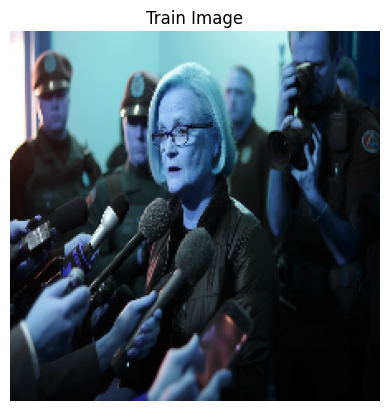

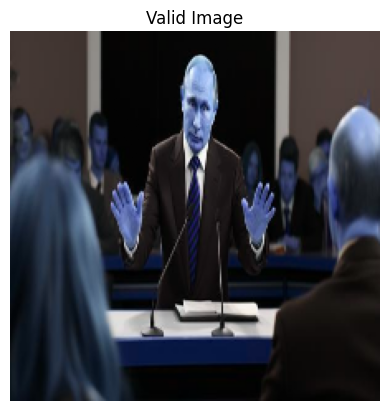

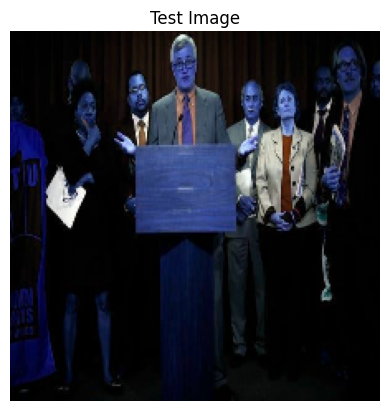

In [18]:
import matplotlib.pyplot as plt
import cv2

def show_image(image_tensor, title="Image"):
    img = image_tensor.numpy().transpose(1, 2, 0)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

train_sample_idx = 0
valid_sample_idx = 0
test_sample_idx = 0

train_sample = train_dataset[train_sample_idx]
valid_sample = valid_dataset[valid_sample_idx]
test_sample = test_dataset[test_sample_idx]

show_image(train_sample["image"], title="Train Image")
show_image(valid_sample["image"], title="Valid Image")
show_image(test_sample["image"], title="Test Image")

In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAXLEN = 25

train_tokenized_pad = pad_sequences(
    train_tokenized,
    maxlen=MAXLEN,
    truncating='post',
    padding='post',
    dtype='float32'
)

valid_tokenized_pad = pad_sequences(
    valid_tokenized,
    maxlen=MAXLEN,
    truncating='post',
    padding='post',
    dtype='float32'
)

test_tokenized_pad = pad_sequences(
    test_tokenized,
    maxlen=MAXLEN,
    truncating='post',
    padding='post',
    dtype='float32'
)

print("Padded train sequences shape:", train_tokenized_pad.shape)
print("Padded validation sequences shape:", valid_tokenized_pad.shape)
print("Padded test sequences shape:", test_tokenized_pad.shape)

Padded train sequences shape: (7000, 25)
Padded validation sequences shape: (1500, 25)
Padded test sequences shape: (1500, 25)


## Model

We also define the different layers that we will be using for  the model.

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_title_images(nn.Module):
    def __init__(self, image_dimx, nlabels, embedding_matrix):
        super().__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32), requires_grad=False)

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=3, kernel_size=5, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.final_dim = int(((image_dimx - 4) / 2 - 4) / 2)

        self.filter_sizes = [2, 3, 4, 5]
        self.num_filters = 50
        self.convs_concat = nn.ModuleList([
            nn.Conv2d(1, self.num_filters, (k, embedding_dim)) for k in self.filter_sizes
        ])

        self.fc1 = nn.Linear(200 + 3 * self.final_dim * self.final_dim, 256)
        self.fc2 = nn.Linear(256, nlabels)

        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x_image, x_title):
        x_image = self.relu(self.conv1(x_image))
        x_image = self.maxpool(x_image)
        x_image = self.relu(self.conv2(x_image))
        x_image = self.maxpool(x_image)
        x_image = x_image.view(x_image.size(0), -1)

        x_title = self.embedding(x_title)
        x_title = x_title.unsqueeze(1)
        x_title = [F.relu(conv(x_title)).squeeze(3) for conv in self.convs_concat]
        x_title = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x_title]
        x_title = torch.cat(x_title, 1)

        x = torch.cat((x_image, x_title), dim=1)
        x = self.relu(self.fc1(x))
        x = self.logsoftmax(self.fc2(x))
        return x

##**Model Training Loop**

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_CNN_image_text = model_CNN_image_text.to(device).float()
model_CNN_image_text.train()

BATCH_SIZE = 60
IMAGE_SIZE = 560
MAXLEN = 25
NUM_CLASSES = 2

def pad_images_cv(img):
    img_resized = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img_resized = img_resized.transpose((2, 0, 1))
    return (img_resized / 255.0).astype(np.float32)

images_tensor = torch.zeros(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE).to(device).float()
titles_tensor = torch.zeros(BATCH_SIZE, MAXLEN).long().to(device)
labels_tensor = torch.zeros(BATCH_SIZE).long().to(device)

repetitions_train = 0
accuracy_train = 0
counter = 0

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model_CNN_image_text.parameters(), lr=0.001)

PATH = "/content/mirage_news_images/train/"

for i in range(len(train_images_final)):
    img_path = PATH + train_images_final[i]

    if os.path.exists(img_path):
        img = cv2.imread(img_path)

        if img is not None:
            counter += 1
            img_padded = pad_images_cv(img)

            img_tensor = torch.tensor(img_padded, dtype=torch.float32).to(device)
            title_tensor = torch.tensor(train_tokenized_pad[i], dtype=torch.long).to(device)
            label_tensor = torch.tensor(train_labels[i], dtype=torch.long).to(device)

            images_tensor[counter - 1] = img_tensor
            titles_tensor[counter - 1] = title_tensor
            labels_tensor[counter - 1] = label_tensor

            if counter % BATCH_SIZE == 0:
                repetitions_train += 1

                optimizer.zero_grad()
                outputs = model_CNN_image_text(images_tensor, titles_tensor)
                loss = criterion(outputs, labels_tensor)
                loss.backward()
                optimizer.step()

                _, predicted = torch.max(outputs, 1)
                correct = (predicted == labels_tensor).sum().item()
                batch_acc = correct / BATCH_SIZE
                accuracy_train += batch_acc

                images_tensor.zero_()
                titles_tensor.zero_()
                labels_tensor.zero_()
                counter = 0

                if repetitions_train % 100 == 0:
                    print(f"[{repetitions_train}] Training Accuracy: {accuracy_train / repetitions_train:.4f}")

if counter > 0:
    optimizer.zero_grad()
    outputs = model_CNN_image_text(images_tensor[:counter], titles_tensor[:counter])
    loss = criterion(outputs, labels_tensor[:counter])
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels_tensor[:counter]).sum().item()
    batch_acc = correct / counter
    accuracy_train += batch_acc

    print(f"[{repetitions_train + 1}] Training Accuracy (Last Batch): {accuracy_train / (repetitions_train + 1):.4f}")

print("Training loop complete.")

[100] Training Accuracy: 0.5887
[117] Training Accuracy (Last Batch): 0.6100
Training loop complete.


##**Model Training and Validation Loop**

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
from tqdm import tqdm

BATCH_SIZE = 60
IMAGE_SIZE = 560
MAXLEN = 25
NUM_CLASSES = 2
EPOCHS = 50
PATIENCE = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_CNN_image_text = model_CNN_image_text.to(device).float()

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model_CNN_image_text.parameters(), lr=0.001)

def pad_images_cv(img):
    img_resized = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img_resized = img_resized.transpose((2, 0, 1))
    return (img_resized / 255.0).astype(np.float32)

best_val_acc = 0
epochs_no_improve = 0

for epoch in range(1, EPOCHS + 1):
    model_CNN_image_text.train()
    counter = 0
    accuracy_train = 0
    repetitions_train = 0

    images_tensor = torch.zeros(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE).to(device).float()
    titles_tensor = torch.zeros(BATCH_SIZE, MAXLEN).long().to(device)
    labels_tensor = torch.zeros(BATCH_SIZE).long().to(device)

    loop = tqdm(range(len(train_images_final)), desc=f"Epoch {epoch}/{EPOCHS}", ncols=100)

    for i in loop:
        img = cv2.imread("/content/mirage_news_images/train/" + train_images_final[i])

        if img is not None:
            img_padded = pad_images_cv(img)
            title_sequence = train_tokenized_pad[i]
            label = int(train_labels[i])

            img_tensor = torch.tensor(img_padded, dtype=torch.float32).to(device)
            title_tensor = torch.tensor(title_sequence, dtype=torch.long).to(device)
            label_tensor = torch.tensor(label, dtype=torch.long).to(device)

            images_tensor[counter] = img_tensor
            titles_tensor[counter] = title_tensor
            labels_tensor[counter] = label_tensor

            counter += 1

            if counter == BATCH_SIZE:
                repetitions_train += 1
                optimizer.zero_grad()

                outputs = model_CNN_image_text(images_tensor, titles_tensor)
                loss = criterion(outputs, labels_tensor)
                loss.backward()
                optimizer.step()

                _, predicted = torch.max(outputs, 1)
                correct = (predicted == labels_tensor).sum().item()
                accuracy_train += correct / BATCH_SIZE

                loop.set_postfix(Training_Accuracy=accuracy_train / repetitions_train)

                images_tensor.zero_()
                titles_tensor.zero_()
                labels_tensor.zero_()
                counter = 0

    print(f"Epoch {epoch}/{EPOCHS} Training Accuracy: {accuracy_train / repetitions_train:.4f}")

    model_CNN_image_text.eval()
    counter = 0
    accuracy_valid = 0
    repetitions_valid = 0

    images_tensor = torch.zeros(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE).to(device).float()
    titles_tensor = torch.zeros(BATCH_SIZE, MAXLEN).long().to(device)
    labels_tensor = torch.zeros(BATCH_SIZE).long().to(device)

    with torch.no_grad():
        for i in range(len(valid_images_final)):
            img = cv2.imread("/content/mirage_news_images/valid/" + valid_images_final[i])
            if img is not None:
                img_padded = pad_images_cv(img)

                images_tensor[counter] = torch.from_numpy(img_padded).to(device)
                titles_tensor[counter] = torch.from_numpy(valid_tokenized_pad[i]).long().to(device)
                labels_tensor[counter] = torch.tensor(valid_labels[i], dtype=torch.long).to(device)

                counter += 1

                if counter == BATCH_SIZE:
                    repetitions_valid += 1
                    out = model_CNN_image_text(images_tensor, titles_tensor)
                    _, top_class = out.topk(1, dim=1)
                    equals = (top_class.squeeze() == labels_tensor)
                    accuracy_valid += torch.mean(equals.type(torch.FloatTensor)).item()

                    images_tensor.zero_()
                    titles_tensor.zero_()
                    labels_tensor.zero_()
                    counter = 0

    val_acc = accuracy_valid / repetitions_valid
    print(f"Epoch {epoch}/{EPOCHS} Validation Accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model_CNN_image_text.state_dict(), "best_model.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve == PATIENCE:
            print("Early stopping triggered.")
            break

Epoch 1/50: 100%|█████████████████████| 7000/7000 [01:08<00:00, 101.89it/s, Training_Accuracy=0.805]


Epoch 1/50 Training Accuracy: 0.8055
Epoch 1/50 Validation Accuracy: 0.7987


Epoch 2/50: 100%|█████████████████████| 7000/7000 [01:08<00:00, 101.64it/s, Training_Accuracy=0.875]


Epoch 2/50 Training Accuracy: 0.8749
Epoch 2/50 Validation Accuracy: 0.7947


Epoch 3/50: 100%|█████████████████████| 7000/7000 [01:08<00:00, 102.44it/s, Training_Accuracy=0.917]


Epoch 3/50 Training Accuracy: 0.9174
Epoch 3/50 Validation Accuracy: 0.7620


Epoch 4/50: 100%|█████████████████████| 7000/7000 [01:07<00:00, 103.83it/s, Training_Accuracy=0.955]


Epoch 4/50 Training Accuracy: 0.9546
Epoch 4/50 Validation Accuracy: 0.7840
Early stopping triggered.


##**Model Training, Validation and Testing Loop**

In [27]:
import torch
import torch.nn as nn
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix

BATCH_SIZE = 60
IMAGE_SIZE = 560
MAXLEN = 25
NUM_CLASSES = 2
EPOCHS = 50
PATIENCE = 5
TRAIN_PATH = "/content/mirage_news_images/train/"
TEST_PATH = "/content/mirage_news_images/test/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def pad_images(img):
    img_resized = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img_resized = img_resized.transpose((2, 0, 1))
    return (img_resized / 255.0).astype(np.float32)

train_valid_tokenized_pad = np.concatenate((train_tokenized_pad, valid_tokenized_pad), axis=0)
train_valid_labels = train_labels + valid_labels
train_valid_images_final = train_images_final + valid_images_final
train_valid_images_final, train_valid_tokenized_pad, train_valid_labels = shuffle(
    train_valid_images_final, train_valid_tokenized_pad, train_valid_labels, random_state=42
)

embedding_matrix_tensor = torch.tensor(embedding_matrix_gv_300, dtype=torch.float32).to(device)
model_CNN_image_text_final = CNN_title_images(image_dimx=IMAGE_SIZE, nlabels=NUM_CLASSES, embedding_matrix=embedding_matrix_tensor).to(device).float()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model_CNN_image_text_final.parameters(), lr=0.001)

best_accuracy = 0
patience_counter = 0

for epoch in range(EPOCHS):
    model_CNN_image_text_final.train()
    counter = 0
    accuracy_train = 0
    total_batches = 0

    images_tensor = torch.zeros(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE).to(device).float()
    titles_tensor = torch.zeros(BATCH_SIZE, MAXLEN).long().to(device)
    labels_tensor = torch.zeros(BATCH_SIZE).long().to(device)

    for i in tqdm(range(len(train_valid_images_final)), desc=f"Epoch {epoch+1}/{EPOCHS}"):
        img = cv2.imread(TRAIN_PATH + train_valid_images_final[i])
        if img is not None:
            img_padded = pad_images(img)
            images_tensor[counter] = torch.from_numpy(img_padded).to(device)
            titles_tensor[counter] = torch.tensor(train_valid_tokenized_pad[i], dtype=torch.long).to(device)
            labels_tensor[counter] = torch.tensor(train_valid_labels[i], dtype=torch.long).to(device)
            counter += 1

            if counter == BATCH_SIZE:
                optimizer.zero_grad()
                out = model_CNN_image_text_final(images_tensor, titles_tensor)
                loss = criterion(out, labels_tensor)
                loss.backward()
                optimizer.step()

                _, top_class = out.topk(1, dim=1)
                equals = (top_class == labels_tensor.view(-1, 1))
                accuracy_train += equals.float().mean().item()
                total_batches += 1

                images_tensor.zero_()
                titles_tensor.zero_()
                labels_tensor.zero_()
                counter = 0

    epoch_accuracy = accuracy_train / total_batches if total_batches > 0 else 0
    print(f"Epoch {epoch+1} Accuracy: {epoch_accuracy:.4f}")

    if epoch_accuracy > best_accuracy:
        best_accuracy = epoch_accuracy
        torch.save(model_CNN_image_text_final.state_dict(), 'best_model_with_images.pt')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

model_CNN_image_text_final.load_state_dict(torch.load('best_model_with_images.pt'))
model_CNN_image_text_final.eval()

counter = 0
images_tensor = torch.zeros(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE).to(device).float()
titles_tensor = torch.zeros(BATCH_SIZE, MAXLEN).long().to(device)
labels_tensor = torch.zeros(BATCH_SIZE).long().to(device)

predictions = np.array([])
labels_test = np.array([])

with torch.no_grad():
    for i in range(len(test_images_final)):
        img = cv2.imread(TEST_PATH + test_images_final[i])
        if img is not None:
            img_padded = pad_images(img)
            images_tensor[counter] = torch.from_numpy(img_padded).to(device)
            titles_tensor[counter] = torch.tensor(test_tokenized_pad[i], dtype=torch.long).to(device)
            labels_tensor[counter] = torch.tensor(test_labels[i], dtype=torch.long).to(device)
            counter += 1

            if counter == BATCH_SIZE:
                out = model_CNN_image_text_final(images_tensor, titles_tensor)
                _, top_class = out.topk(1, dim=1)

                predictions = np.concatenate((predictions, top_class.view(-1).cpu().numpy()))
                labels_test = np.concatenate((labels_test, labels_tensor.cpu().numpy()))

                images_tensor.zero_()
                titles_tensor.zero_()
                labels_tensor.zero_()
                counter = 0

if counter > 0:
    out = model_CNN_image_text_final(images_tensor[:counter], titles_tensor[:counter])
    _, top_class = out.topk(1, dim=1)
    predictions = np.concatenate((predictions, top_class.view(-1).cpu().numpy()))
    labels_test = np.concatenate((labels_test, labels_tensor[:counter].cpu().numpy()))

print("Classification Report:")
print(classification_report(labels_test, predictions, digits=4, zero_division=1))

print("Confusion Matrix:")
print(confusion_matrix(labels_test, predictions))

<ipython-input-24-a6e03edb7feb>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=True)
Epoch 1/50: 100%|██████████| 8500/8500 [01:12<00:00, 116.90it/s]


Epoch 1 Accuracy: 0.6557


Epoch 2/50: 100%|██████████| 8500/8500 [01:10<00:00, 120.72it/s]


Epoch 2 Accuracy: 0.8335


Epoch 3/50: 100%|██████████| 8500/8500 [01:09<00:00, 121.91it/s]


Epoch 3 Accuracy: 0.8950


Epoch 4/50: 100%|██████████| 8500/8500 [01:09<00:00, 123.13it/s]


Epoch 4 Accuracy: 0.9247


Epoch 5/50: 100%|██████████| 8500/8500 [01:10<00:00, 121.23it/s]


Epoch 5 Accuracy: 0.9430


Epoch 6/50: 100%|██████████| 8500/8500 [01:08<00:00, 123.84it/s]


Epoch 6 Accuracy: 0.9914


Epoch 7/50: 100%|██████████| 8500/8500 [01:09<00:00, 121.83it/s]


Epoch 7 Accuracy: 0.9950


Epoch 8/50: 100%|██████████| 8500/8500 [01:10<00:00, 121.29it/s]


Epoch 8 Accuracy: 0.9968


Epoch 9/50: 100%|██████████| 8500/8500 [01:09<00:00, 122.79it/s]


Epoch 9 Accuracy: 0.9990


Epoch 10/50: 100%|██████████| 8500/8500 [01:10<00:00, 120.94it/s]


Epoch 10 Accuracy: 1.0000


Epoch 11/50: 100%|██████████| 8500/8500 [01:09<00:00, 122.94it/s]


Epoch 11 Accuracy: 1.0000


Epoch 12/50: 100%|██████████| 8500/8500 [01:09<00:00, 122.42it/s]


Epoch 12 Accuracy: 1.0000


Epoch 13/50: 100%|██████████| 8500/8500 [01:08<00:00, 123.52it/s]


Epoch 13 Accuracy: 1.0000


Epoch 14/50: 100%|██████████| 8500/8500 [01:09<00:00, 122.30it/s]


Epoch 14 Accuracy: 1.0000


Epoch 15/50: 100%|██████████| 8500/8500 [01:08<00:00, 124.78it/s]
<ipython-input-27-08a681f2baba>:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_CNN_image_text_fina

Epoch 15 Accuracy: 1.0000
Early stopping triggered.
Classification Report:
              precision    recall  f1-score   support

         0.0     0.7924    0.8347    0.8130       750
         1.0     0.8254    0.7813    0.8027       750

    accuracy                         0.8080      1500
   macro avg     0.8089    0.8080    0.8079      1500
weighted avg     0.8089    0.8080    0.8079      1500

Confusion Matrix:
[[626 124]
 [164 586]]


Confusion Matrix:
 [[626 124]
 [164 586]]


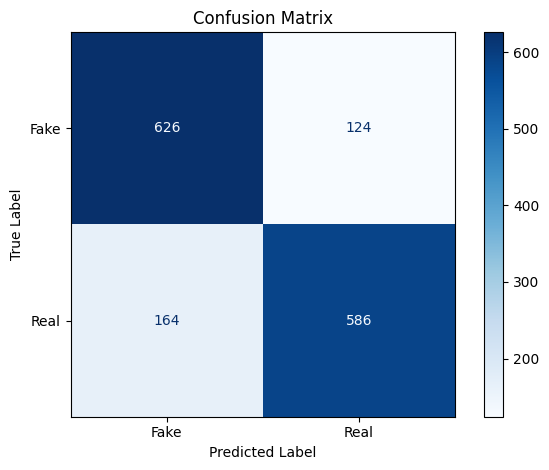

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels_test, predictions)

print("Confusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap=plt.cm.Blues, values_format='d')

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.tight_layout()
plt.show()